In [3]:
import numpy as np
import matplotlib.pyplot as plt
import numexpr as ne
from csc.sparse_coding import get_path_matrix_cy, from_path_matrix_to_event_indexes
from scipy.sparse.linalg import svds

In [5]:
def get_rk1_approx(atom):
    # atom of shape (n_samples_atom, n_dims)
    # temporal_map of shape (n_samples_atom,)
    # spatial_map of shape (n_dims,)
    # spatial_map has unit norm
    U, sigma, VT = svds(atom, k=1, which="LM")
    temporal_map = sigma[0] * U[:, 0]
    spatial_map = VT[0]

    # in order to keep the argmin at the same temporal location
    shift = int(template.min(1).argmin()) - temporal_map.argmin()
    temporal_map = np.roll(temporal_map, shift=shift)
    return temporal_map, spatial_map

def find_spike_times(signal, spatial_map, temporal_map, penalty=0.0):
    # signal, shape (n_samples, n_dims)
    # spatial_map, shape (n_dims,). Should have unit norm
    # temporal_map, shape (n_samples_atom,)
    # Return an array with the spike times for a single template
    n_samples_atom, = temporal_map.shape
    spatial_corr = np.einsum("td,d->t", signal, spatial_map)
    full_corr = np.correlate(spatial_corr, temporal_map, mode="valid")
    temporal_map_sq_norm = np.sum(np.square(temporal_map))
    cost_vec = ne.evaluate("temporal_map_sq_norm - 2 * full_corr").astype(np.float32)
    # find the best temporal support for the activations
    path_vec = get_path_matrix_cy(
        cost_vec=penalty + cost_vec, atom_length=n_samples_atom
    )
    path_vec = np.asarray(path_vec)
    activated_time_indexes = np.array(
        from_path_matrix_to_event_indexes(path_vec), dtype=int
    )
    return activated_time_indexes

## Example of rank-1 approximation

In [6]:
template = np.random.normal(size=(50, 64*64))  # shape (n_samples_atom, n_dims)

# temporal_map of shape (n_samples_atom,)
# spatial_map of shape (n_dims,)
# spatial_map has unit norm
temporal_map, spatial_map = get_rk1_approx(template)

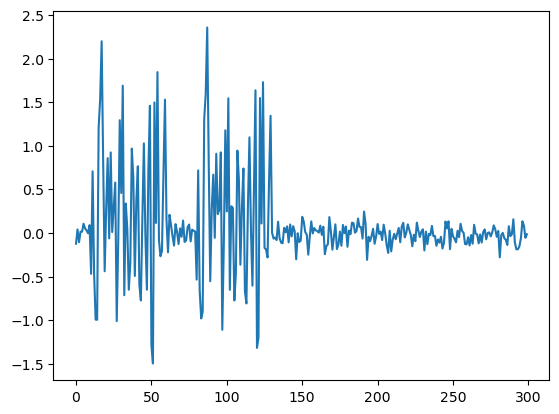

In [9]:
# create a dummy signal
signal = np.random.normal(scale=0.1, size=(300, 64*64))
n_samples_atom = template.shape[0]
signal[10:10+n_samples_atom] += template
signal[80:80+n_samples_atom] += template
plt.plot(signal[:, 0])

In [10]:
# find the spike times
find_spike_times(signal, temporal_map=temporal_map, spatial_map=spatial_map)

array([15, 85])